### To Do (11/15):
0. Check physics engine parameters for more effective settings for locomotion
1. Data gathering changes:
    * Run for 2-3 seconds, to alleviate transient response
    * Then run each parameter settings for 5 cycles
    * Start state should be after 2-3 of these cycles completed
    * End state should be after 5 cycles completed
    * **Run for many more datapoints** - aim for 10k initially
2. Data analysis changes:
    * Divide displacement measures by time (end-start)
    * Split datapoints into "bins" (+/- 10 degrees) and maximize displacement in each bin 
    * Ensure within each bin, we have a sufficient amount of samples
    * Change measure to maximal displacement along chosen vector (dot product)
3. Run gaits with different initial conditions and measure robustness

# Data Processing
### (skip to below for charts and discussion)

In [1]:
import os
import matplotlib.cm as cmx
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from IPython.display import display
from mp_learning import snake_data
import matplotlib
import numpy as np
import mpld3
from mpld3 import fig_to_html, plugins

# mpld3.enable_notebook()

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

# HELPER FUNCTIONS
# 1 - Calculate slope of points, input: 1x91 snake state array
def slope ( points, m="no_debug" ):
    X, Y = [], []
    x_mid = points[39]
    y_mid = points[40]
    for i in [0,6]:
        X.append(points[i*13] )
        Y.append(points[(i*13)+1] )
    s_x = np.std(X)
    s_y = np.std(Y)
    corr_x_y = np.corrcoef(X,Y)
    slope = corr_x_y[0,1]*(s_y / s_x)
    quadrant = 0
    point = []
    if (X[0] > X[-1]) and (slope >= 0.0):
        quadrant = 1
        point = [1, slope]
    elif (X[0] < X[-1]) and (slope < 0.0):
        quadrant = 2
        point = [-1, -slope]
    elif (X[0] < X[-1]) and (slope >= 0.0):
        quadrant = 3
        point = [-1, -slope]
    elif (X[0] > X[-1]) and (slope < 0.0):
        quadrant = 4
        point = [1, slope]
    else:
        raise ValueError("Invalid slope/quadrant computation")
    if (m == "debug"):
        print "X: ",X
        print "Y: ",Y
        print "quad: ", quadrant
        print "slope: ", slope
        print "point: ", point
        point1 = [10, 10*slope]
        point2 = [-10, -10*slope]
        plot_snake_state_pts(X,Y, point1, point2)
    return point, quadrant

def scatter3d(x, title1, y, title2, z, title3, cs, colorsMap='jet'):
    cm = plt.get_cmap(colorsMap)
    cNorm = matplotlib.colors.Normalize(vmin=min(cs), vmax=max(cs))
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
    fig = plt.figure(figsize=(10,6))
    ax = Axes3D(fig)
    ax.scatter(x, y, z)
    scalarMap.set_array(cs)
    fig.colorbar(scalarMap)
    ax.set_xlabel(title1)
    ax.set_ylabel(title2)
    ax.set_zlabel(title3)
    plt.show()
    
def plot_snake_state ( state ):
    pts = []
    for i in range(0,7):
        pts.append(state[i*13:i*13+2])
    pts = np.asarray(pts)
    fig = plt.figure()
    plt.scatter(pts[:,0], pts[:,1])
    plt.ylim([-40,40])
    plt.xlim([-40,40])
    plt.show()
    
def get_snake_xy ( state ):
    pts = []
    for i in range(0,7):
        pts.append(state[i*13:i*13+2])
    pts = np.asarray(pts)
    return pts
    
def plot_snake_state_pts ( points_x, points_y, pt1, pt2):
#     pts = np.asarray(np.concatenate((points_x,points_y),axis=1)
    fig = plt.figure()
    ax = fig.gca()
    plt.scatter(np.asarray(points_x), np.asarray(points_y))
    plt.ylim([-25,25])
    plt.xlim([-25,25])
    ax.set_xticks(np.arange(-25,25,5))
    ax.set_yticks(np.arange(-25,25,5))
    
    ax.plot([pt1[0], pt2[0]],[pt1[1], pt2[1]], "r--")
    
    plt.grid()
    plt.show()

FILEHOME = os.path.abspath(os.path.curdir)
datapath = FILEHOME + '/data/cpg_output_snake_multistates.txt'

model = snake_data.Model(datapath, 'snake')
gp = snake_data.SGPRegression(model)


/home/colin/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


warning in stationary: failed to import cython module: falling back to numpy


In [36]:
rnd_idxs = np.random.randint(0, gp.data_model.train_data.shape[0],75)
print rnd_idxs

gp.train(gp.data_model.train_data[rnd_idxs,:], gp.data_model.train_labels[rnd_idxs,:])

gpdata = gp.data_model.test_data[:50, :]

gplabels = gp.data_model.test_labels[:50, :]
gppred, gppredvar = gp.test(gpdata)

gppred_diff = np.abs(gppred - gplabels)

print "110", "\t\t", np.mean(gppred_diff), "\t", np.mean(gppredvar)


[503 457 239 264  99 284 436 440 294 329 436 402 503 327 300 512 362 140
 273 203 463 275 498 419  10 499 276 378 499  47 214 137 386 402 239  92
 507 394 478 419   3 340 303 250 505 197 262 103 229 366  71 357 244 207
 226 451 461  46 508 470 149 378  21 465 235 254 383  94 356   5 305 217
  82 358 383]
110 		4.65752108052 	41.8521731402


In [64]:
print "Label\t\tPrediction\tDiff\t\tVariance"
for i in range(0,len(gppred)):
    print gplabels[i], "\t", gppred[i], "\t", gppred_diff[i], "\t", gppredvar[i]
  

Label		Prediction	Diff		Variance
[-20.11757469] 	[-0.3978481] 	[ 19.71972659] 	[ 265.84358017]
[ 14.74782658] 	[ 0.00855005] 	[ 14.73927652] 	[ 265.87857907]
[-10.95188046] 	[ 0.64858472] 	[ 11.60046518] 	[ 265.48254346]
[-2.50532818] 	[ 0.03417463] 	[ 2.53950281] 	[ 265.57915515]
[ 17.67519951] 	[ 0.33395497] 	[ 17.34124454] 	[ 265.86268343]
[ 9.71807575] 	[ 0.52259555] 	[ 9.19548021] 	[ 265.4601466]
[ 19.77524757] 	[ 1.26470265] 	[ 18.51054493] 	[ 265.44771539]
[ 22.42586517] 	[ 0.01685225] 	[ 22.40901293] 	[ 265.9038492]
[-31.73568153] 	[-4.21382829] 	[ 27.52185324] 	[ 261.25730215]
[ 24.00936699] 	[ 0.66887774] 	[ 23.34048925] 	[ 265.62610778]
[ 1.16128933] 	[ 0.25630915] 	[ 0.90498019] 	[ 243.5658526]
[-0.20756312] 	[-0.01005206] 	[ 0.19751105] 	[ 265.6552752]
[-0.11162177] 	[ 0.02164265] 	[ 0.13326442] 	[ 252.46498353]
[ 16.98328209] 	[ 0.24265416] 	[ 16.74062793] 	[ 265.79300836]
[-1.54980421] 	[ 0.17920259] 	[ 1.7290068] 	[ 264.82104384]
[-30.72707939] 	[-0.02032862] 	[ 30.7067

In [39]:
rnd_idxs = np.random.randint(0, gp.data_model.train_data.shape[0],10)
gp.train(gp.data_model.train_data[rnd_idxs,:], gp.data_model.train_labels[rnd_idxs,:])

print "Iteration\tAvg. Diff\t\tAvg. Variance"
print "-------------------------------------"
for i in range(0,100):
    # Sample random controls and find control with max variance
    controls_samp = np.concatenate(((np.random.rand(1000,1)*0.6)+0.4,
        (np.random.rand(1000,1)*0.875)+0.125,
        (np.random.rand(1000,1)*0.8)+0.2,
        (np.random.rand(1000,1)*0.8)+0.2), axis=1)
    gp_pred, gp_predvar = gp.test(controls_samp)
    max_var = controls_samp[np.argmax(gp_predvar)]

    # Find nearest existing control to sampled max variance
    min_dist = 100000.0
    control_idx = -1
    for j,val in enumerate(gp.data_model.train_data):
        if np.sqrt(np.sum(np.square(gp.data_model.train_data[j] - max_var))) < min_dist:
            if j not in rnd_idxs:
                min_dist = np.sqrt(np.sum(np.square(gp.data_model.train_data[j] - max_var)))
                control_idx = j
    # Add new data point to training indices
    rnd_idxs = np.insert(rnd_idxs, len(rnd_idxs), control_idx)
    
    # Train including new data point and output results
    gp.train(gp.data_model.train_data[rnd_idxs,:], gp.data_model.train_labels[rnd_idxs,:])
    
    gpdata = gp.data_model.test_data[:50, :]
    gplabels = gp.data_model.test_labels[:50, :]
    gppred, gppredvar = gp.test(gpdata)

    gppred_diff = np.abs(gppred - gplabels)
    
    print i, "\t\t", np.mean(gppred_diff), "\t", np.mean(gppredvar)
#     print rnd_idxs

0 		4.65752108052 	41.8521731402
Iteration	Avg. Diff		Avg. Variance
-------------------------------------
0 		10.1064049467 	224.808573736
[503 457 239 264  99 284 436 440 294 329 436 402 503 327 300 512 362 140
 273 203 463 275 498 419  10 499 276 378 499  47 214 137 386 402 239  92
 507 394 478 419   3 340 303 250 505 197 262 103 229 366  71 357 244 207
 226 451 461  46 508 470 149 378  21 465 235 254 383  94 356   5 305 217
  82 358 383 220]
1 		4.77421688697 	40.3670028273
[503 457 239 264  99 284 436 440 294 329 436 402 503 327 300 512 362 140
 273 203 463 275 498 419  10 499 276 378 499  47 214 137 386 402 239  92
 507 394 478 419   3 340 303 250 505 197 262 103 229 366  71 357 244 207
 226 451 461  46 508 470 149 378  21 465 235 254 383  94 356   5 305 217
  82 358 383 220 172]
2 		4.91558113024 	28.3342788657
[503 457 239 264  99 284 436 440 294 329 436 402 503 327 300 512 362 140
 273 203 463 275 498 419  10 499 276 378 499  47 214 137 386 402 239  92
 507 394 478 419   3 340 

In [9]:
print np.unique(rnd_idxs, return_counts=True)

(array([ 10,  11,  13,  14,  16,  26,  44,  50,  54,  56,  62,  66,  68,
        70,  89,  92, 102, 115, 118, 121, 123, 125, 128, 129, 136, 137,
       139, 140, 141, 143, 148, 163, 166, 171, 172, 175, 179, 180, 182,
       187, 197, 198, 203, 205, 207, 208, 215, 216, 220, 231, 232, 233,
       234, 257, 258, 260, 262, 263, 267, 268, 273, 275, 277, 279, 289,
       290, 296, 306, 322, 327, 331, 334, 335, 344, 348, 351, 354, 362,
       364, 366, 373, 379, 388, 389, 392, 393, 413, 419, 427, 435, 454,
       455, 463, 466, 468, 471, 480, 482, 483, 486, 488, 491, 498, 499,
       501, 502, 503, 504, 506, 508]), array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))


In [76]:
# 1 - Figure out linear regression of link locations for slope of result
# print slope_start
model.heading_change_norm = []
model.heading_change = []
for i in range(0, model.end_states.shape[0]):
    slope_start, start_quadrant = slope( model.start_states[i,:])
    slp, quad = slope(model.end_states[i,:])
    angle = angle_between(slope_start, slp)*180/np.pi
#     if (np.asarray(np.asarray(slp)-np.asarray(slope_start))[1] < 0.0):
#         angle = angle*-1
    model.heading_change.append(angle)
    model.heading_change_norm.append(angle * 1000.0 / model.durations[i])
model.heading_change_norm = np.asarray(model.heading_change_norm)
model.heading_change = np.asarray(model.heading_change)

# 2 - Calc displacement angle and store
# 3 - Calc total displacement
model.disp_angles = []
model.disp = []
model.disp_along_heading = []
for i in range(0,model.states.shape[0]):
    start_disp = np.asarray(model.start_states[i,39:41])
    end_disp = np.asarray(model.end_states[i,39:41])
    
    start_slope, quadrant = slope(model.start_states[i,:])
    end_slope, quadrant = slope(model.end_states[i,:])
    start_vec = np.asarray(start_slope)
    end_vec = np.asarray((end_disp - start_disp)[0:2])
    
    disp_total = np.sqrt(np.sum(np.square(start_disp - end_disp)))
    disp_angle = angle_between(start_vec, end_vec)*180/np.pi
#     if ((end_disp - start_disp)[1] < 0.0):
#         disp = disp * -1
#     print i, ": ", disp_total

    slope_unit = unit_vector(np.asarray(end_slope))
    disp_along_heading = np.dot(end_vec,slope_unit)
    
    model.disp_along_heading.append(disp_along_heading * 1000.0 / model.durations[i])
    model.disp_angles.append(disp_angle * 1000.0 / model.durations[i])
    model.disp.append(disp_total * 1000.0 / model.durations[i])
model.disp_along_heading = np.asarray(model.disp_along_heading)
model.disp_angles = np.asarray(model.disp_angles)
model.disp = np.asarray(model.disp)

# # 3 - New dimensions of data:
# print model.start_states.shape
# print model.end_states.shape

# 4 - Remove points where heading change and displacement direction disagree
unstable_thresh = np.abs(model.disp_angles - model.heading_change_norm) < 50.0
model.states = model.states[unstable_thresh[:,0]]
model.controls = model.controls[unstable_thresh[:,0]]
model.durations = model.durations[unstable_thresh[:,0]]
model.disp = model.disp[unstable_thresh[:,0]]
model.disp_angles = model.disp_angles[unstable_thresh[:,0]]
model.heading_change_norm = model.heading_change_norm[unstable_thresh[:,0]]
model.heading_change = model.heading_change[unstable_thresh[:,0]]
model.disp_along_heading = model.disp_along_heading[unstable_thresh[:,0]]


AttributeError: Model instance has no attribute 'end_states'

# Analysis
Note: All below analysis has been performed over random sampling of four parameter values 

$$\textrm{freq, phase_offset, Ampl_left, Ampl_right} <=> (\nu,\delta\phi, \alpha_l, \alpha_r)$$

Where our goal is to find parameter settings which maximize displacement in "useful" directions, e.g. -45$^\circ$, 0$^\circ$, 45$^\circ$.

Above calculations give us:
* **heading change**: calculated as rotation (around z-axis) of linear interpolation of snake's configuration from start to end of applying the parameterized control sequence for 10s
* **displacement angle**: again calculated around z-axis, this is the angle between origin & snake's middle link from $t_{start} = 0s$ and $t_{end} = 10s$
* **total displacement**: this is the L2 distance between the middle link from start to end

### 1 - Plotting distribution of heading changes
Here, we just expect/want to see that we have a good variety of heading changes for the snake's configuration so that we can choose from a variety of "gaits" to use in SST/iSST

In [2]:
# Histogram with modified axes/grid
fig = plt.figure(figsize=(8,6))

ax = fig.add_subplot(111)
ax.grid(color='lightgrey', linestyle='solid')

bins = np.linspace(-180,180,36)
_ = ax.hist(model.heading_change_norm, bins, histtype='stepfilled', fc='lightblue', alpha=0.5)
ax.set_ylabel("Count", fontsize=12)
ax.set_xlabel("Heading Change (degrees/second)", fontsize=12)
ax.set_xlim(-90,90)
ax.set_ylim(0,500)
mpld3.display(fig)

### 2 - Checking for good "coverage" over parameter space
Interactive plot of all four variables in pairs, showing sample coverage of parameter space where that space is
* **frequency**: (0.1, 1.0)
* **phase offset**: (0.2, 1.0)
* **ampl left**: (0.25, 0.75)
* **ampl right**: (0.25, 0.75)

In [3]:
fig, axs = plt.subplots(2, 2, figsize=(8,8), sharex='col', sharey='row')
fig.subplots_adjust(hspace=0.3)

# cm = plt.get_cmap('jet')
# cNorm = matplotlib.colors.Normalize(vmin=min(model.disp[:]), vmax=max(model.disp[:]))
# scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
# scalarMap.set_array(model.disp[:])

# ax[0] = fig.add_subplot(211, axisbg='#EEEEEE')
axs.flat[0].grid(color='lightgray', alpha=0.7, linestyle='solid')
axs.flat[0].scatter(model.controls[:,0],model.controls[:,1], s=20, alpha=0.5)
axs.flat[0].set_xlabel("frequency", fontsize=12)
axs.flat[0].set_ylabel("phase offset", fontsize=12)

# ax[0] = fig.add_subplot(211, axisbg='#EEEEEE')
axs.flat[1].grid(color='lightgray', alpha=0.7, linestyle='solid')
axs.flat[1].scatter(model.controls[:,2],model.controls[:,1], s=20, alpha=0.5)
axs.flat[1].set_xlabel("ampl. left", fontsize=12)
axs.flat[1].set_ylabel("phase offset", fontsize=12)

# ax[0] = fig.add_subplot(211, axisbg='#EEEEEE')
axs.flat[2].grid(color='lightgray', alpha=0.7, linestyle='solid')
axs.flat[2].scatter(model.controls[:,0],model.controls[:,3], s=20, alpha=0.5)
axs.flat[2].set_xlabel("frequency", fontsize=12)
axs.flat[2].set_ylabel("ampl. right", fontsize=12)

# ax = fig.add_subplot(212, axisbg='#EEEEEE')
axs.flat[3].grid(color='lightgray', alpha=0.7, linestyle='solid')
points =axs.flat[3].scatter(model.controls[:,2],model.controls[:,3], s=20, alpha=0.5)
axs.flat[3].set_xlabel("ampl. left", fontsize=12)
axs.flat[3].set_ylabel("ampl. right", fontsize=12)

plugins.connect(fig, plugins.LinkedBrush(points))
mpld3.display(fig)

### 3 - Plotting all three measures together
In order to select which parameter values we'd like, we look first at 
1. **heading change v. displacement angle**: Where we would actually expect these to correlate, i.e, if snake rotates to the left, displacement should be in that direction as well
2. **heading change v. total displacement**: Given that the above measures of a certain parameterization are reasonably well correlated, we want to select those which maximize our total displacement of the center link so as to locomote as fast as possible

*Note: below is an interactive chart. Use interaction tools in the toolbar by hovering mouse over bottom left corner or by hovering over individual points in order to see their control parameterizations*

In [4]:
fig, axs = plt.subplots(2, 1, figsize=(8,8), sharex='col')
fig.subplots_adjust(hspace=0.3)

# cm = plt.get_cmap('jet')
# cNorm = matplotlib.colors.Normalize(vmin=min(model.disp[:]), vmax=max(model.disp[:]))
# scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
# scalarMap.set_array(model.disp[:])

# ax[0] = fig.add_subplot(211, axisbg='#EEEEEE')
axs.flat[0].grid(color='lightgray', alpha=0.7, linestyle='solid')
axs.flat[0].scatter(model.heading_change_norm[:],model.disp_angles[:], s=40, alpha=0.5, c=model.disp[:])
axs.flat[0].set_xlabel("heading change ", fontsize=12)
axs.flat[0].set_ylabel("displ. dir ", fontsize=12)
axs.flat[0].set_ylim(-45,45)

# ax = fig.add_subplot(212, axisbg='#EEEEEE')
axs.flat[1].grid(color='lightgray', alpha=0.7, linestyle='solid')
points =axs.flat[1].scatter(model.heading_change_norm[:],model.disp_along_heading[:], s=40, alpha=0.5, c=model.disp[:])
axs.flat[1].set_xlabel("heading change ", fontsize=12)
axs.flat[1].set_ylabel("total displacement ", fontsize=12)
labels = ["Control[{0}]: {1}".format(i,e) for i,e in enumerate(model.controls[:])]
tooltip = plugins.PointLabelTooltip(points, labels)

plugins.connect(fig, plugins.LinkedBrush(points))
plugins.connect(fig, tooltip)
mpld3.display(fig)

In [66]:
print model.controls[306,:]

[ 0.82559264  0.19491065  0.59511465  0.80153501]


### 4 - Finding gaits which maximize displacement along chosen directions
We can easily find those parameterization which maximize our displacement along some desired set of "learned gait" locomotion directions by constraining the search such that both our displacement and heading directions (already positively correlated) both lie within some threshold of the desired direction. 

Below uses thresh=+/-5$^\circ$, and searches for 9 learned gait locomotion directions which meet that criteria and maximize displacement of the middle link.

#### Plot shows resulting configuration of snake in global frame after applying each learned gait for 10s

In [71]:
def rotate_snake(idx,X,Y,degrees):
    s = np.sin(degrees)
    c = np.cos(degrees)

    start_st = get_snake_xy(model.states[idx,19,:])
    cx = start_st[3,0]
    cy = start_st[3,1]
    
    # rotate point
    for i,x in enumerate(X):
        X[i] = (x-cx)*c - (Y[i]-cy)*s
        Y[i] = (x-cx)*s + (Y[i]-cy)*c
        X[i] = X[i] + cx
        Y[i] = Y[i] + cy
        
    return X,Y

# Search for those points which maximize displacement in chosen directions
desired_directions = [-30, -24, -18, -12, -6, 0, 6, 12, 18, 24, 30]
max_d = [0] * len(desired_directions)
allow_thresh = 3
best_indices, best_controls = [0] * len(desired_directions), [0] * len(desired_directions)
for idx in range(0,len(desired_directions)):
    for i, pt in enumerate(model.controls):
        if (
#             (model.disp_angles[i] > desired_directions[idx] - allow_thresh) and 
#             (model.disp_angles[i] < desired_directions[idx] + allow_thresh) and 
            (model.heading_change_norm[i] > desired_directions[idx] - allow_thresh) and 
            (model.heading_change_norm[i] < desired_directions[idx] + allow_thresh)):
                if (model.disp_along_heading[i] > max_d[idx]):
                    max_d[idx] = model.disp_along_heading[i]
                    best_indices[idx] = i
                    best_controls[idx] = pt
for j, pt in enumerate(best_controls):
    print desired_directions[j], ": ", max_d[j], "--> controls[", best_indices[j], "]: ", pt

fig, ax = plt.subplots(1,1, figsize=(8,6))

for e, pt in enumerate(best_indices):
    conf = get_snake_xy(model.states[pt,20,:])
    st_slp, st_quad = slope(model.states[pt,19,:])
#     if e == 1:
    conf[:,0], conf[:,1] = rotate_snake(pt, conf[:,0], conf[:,1], -np.arctan(st_slp[1] / st_slp[0]))
    if st_quad in [2,3]:
        conf[:,0], conf[:,1] = rotate_snake(pt, conf[:,0], conf[:,1], np.pi)
    start_state = get_snake_xy(model.states[pt,19,:])
    for i in range(0,conf.shape[0]):
        conf[i,0] = conf[i,0] - start_state[3,0]
        conf[i,1] = conf[i,1] - start_state[3,1]
    ax.plot(conf[:,0], conf[:,1], lw=2, alpha=0.4, label="Dir:{0}".format(desired_directions[e]))
    ax.scatter(conf[0,0], conf[0,1], s=25)
    ax.scatter(conf[-1,0], conf[-1,1], s=25)
start_conf = np.asarray([[12,0],[8, 0],[4, 0],[0, 0],[-4, 0],[-8, 0],[-12, 0]])
ax.scatter(start_conf[0,0], start_conf[0,1], s=25)
ax.scatter(start_conf[-1,0], start_conf[-1,1], s=25)
ax.plot(start_conf[:,0], start_conf[:,1], lw=5,alpha=0.5, label="Start")
ax.grid(color='lightgray', alpha=0.7)
ax.legend()
mpld3.display(fig)

-30 :  [ 3.80230665] --> controls[ 238 ]:  [ 0.99746531  0.78715253  0.64734775  0.52321428]
-24 :  [ 3.8118341] --> controls[ 564 ]:  [ 0.92973387  0.95333135  0.45838687  0.34355974]
-18 :  [ 4.10345316] --> controls[ 171 ]:  [ 0.5587669   0.8178618   0.45587701  0.44933236]
-12 :  [ 4.37265921] --> controls[ 422 ]:  [ 0.48362902  0.85983253  0.44829234  0.49557993]
-6 :  [ 4.85654116] --> controls[ 151 ]:  [ 0.55467165  0.5171544   0.64518762  0.62826836]
0 :  [ 4.59503746] --> controls[ 469 ]:  [ 0.52339506  0.60874534  0.54892004  0.5856275 ]
6 :  [ 4.12228346] --> controls[ 157 ]:  [ 0.47925481  0.3355014   0.58170986  0.77354425]
12 :  [ 3.48712659] --> controls[ 344 ]:  [ 0.5049063   0.73474592  0.44102111  0.50987077]
18 :  [ 2.93357348] --> controls[ 500 ]:  [ 0.56924254  0.90237182  0.33227897  0.46255082]
24 :  [ 2.87014556] --> controls[ 12 ]:  [ 0.80968571  0.89014173  0.38203457  0.44429228]
30 :  [ 2.23423767] --> controls[ 376 ]:  [ 0.61316478  0.84843963  0.30082101  



# -------- SCRATCH WORK ---------



In [ ]:
idx = 177

plot_snake_state(model.start_states[0,:])
# print model.start_states[0,:]
# plot_snake_state(model.end_states[idx,:])
print model.start_states[0,39:42]

plot_snake_state(model.end_states[idx,:])
print model.end_states[idx,39:42]
# slope(model.end_states[idx,:], m="debug")
# print slope_start

In [393]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

# def angle_between(v1, v2):
#     v1_u = unit_vector(v1)
#     v2_u = unit_vector(v2)
# #     print np.arctan2(v2_u[1], v2_u[0])
# #     print np.arctan2(v1_u[1], v1_u[0])
#     return np.arctan2(v1_u[0], v1_u[1]) - np.arctan2(v2_u[0], v2_u[1])


test_idx = 2950
slope_start, start_quadrant = slope( model.start_states[test_idx,:])
slp, quad = slope(model.end_states[test_idx,:])
angle = angle_between(slope_start, slp)*180/np.pi

start_vec = np.asarray([model.start_states[test_idx,0] - model.start_states[test_idx,39], 
                      model.start_states[test_idx,1] - model.start_states[test_idx,40]])
start_disp = np.asarray(model.start_states[test_idx,39:41])

end_vec = np.asarray([model.end_states[test_idx,0] - model.end_states[test_idx,39], 
                          model.end_states[test_idx,1] - model.end_states[test_idx,40]])
end_disp = np.asarray(model.end_states[test_idx,39:41])

start_disp = np.asarray(model.start_states[test_idx,39:41])
end_disp = np.asarray(model.end_states[test_idx,39:41])

start_slope, quadrant = slope(model.start_states[test_idx,:])
start_vec = np.asarray(start_slope)
end_vec = np.asarray((end_disp - start_disp)[0:2])

disp_total = np.sqrt(np.sum(np.square(start_disp - end_disp)))* 1000 / model.durations[test_idx]
disp_angle = (angle_between(start_vec, end_vec)*180/np.pi)* 1000 / model.durations[test_idx]

print "control: ", model.controls[test_idx,:]
print "duration: ", model.durations[test_idx]
print "-------------------------"
print "total displacement: ", model.disp[test_idx]
print "displacement angle: ", model.disp_angles[test_idx]
print "heading change total: ", model.heading_change[test_idx]
print "heading change norm: ", model.heading_change_norm[test_idx]
print "-------------------------"
print "disp total calc: ", disp_total
print "disp angle calc: ", disp_angle

def rotate_snake(idx,X,Y,degrees):
    s = np.sin(degrees)
    c = np.cos(degrees)

    start_st = get_snake_xy(model.start_states[idx,:])
    cx = start_st[3,0]
    cy = start_st[3,1]
    
    # rotate point
    for i,x in enumerate(X):
        X[i] = (x-cx)*c - (Y[i]-cy)*s
        Y[i] = (x-cx)*s + (Y[i]-cy)*c
        X[i] = X[i] + cx
        Y[i] = Y[i] + cy
        
    return X,Y


fig, ax = plt.subplots(1,1, figsize=(8,6))
slope_start, slope_final = [], []
slp_s, quad_s = slope(model.start_states[test_idx, :])
slope_start.append(model.start_states[test_idx, 39:41] + np.asarray(slp_s)*10)
slope_start.append(model.start_states[test_idx, 39:41])
# slope_start.append(model.start_states[test_idx, 39:41] - np.asarray(slp_s)*10)
slope_start = np.asarray(slope_start)

slp_f, _ = slope(model.end_states[test_idx, :])
slope_final.append(model.end_states[test_idx, 39:41] + np.asarray(slp_f)*10)
slope_final.append(model.end_states[test_idx, 39:41])
# slope_final.append(model.end_states[test_idx, 39:41] + np.asarray(slp_f)*10)
slope_final = np.asarray(slope_final)

# TEST: calculate displacement along vector of heading 
slope_unit = unit_vector(np.asarray(slp_f)*10)
disp_along_heading = np.dot(end_vec,slope_unit)
print "disp vec: ", end_vec
print "slope final: ", slope_unit
print "disp along heading: ", disp_along_heading

print slp_s[1] / slp_s[0]
print -np.arctan(slp_s[1] / slp_s[0])*180/np.pi

conf = get_snake_xy(model.start_states[test_idx,:])
ax.plot(conf[:,0], conf[:,1], lw=2,alpha=0.4, label="start")
ax.scatter(conf[0,0], conf[0,1], s=25)

conf[:,0], conf[:,1] = rotate_snake(test_idx, conf[:,0], conf[:,1], -np.arctan(slp_s[1] / slp_s[0]))
if quad_s in [2,3]:
    conf[:,0], conf[:,1] = rotate_snake(test_idx, conf[:,0], conf[:,1], np.pi)
ax.plot(conf[:,0], conf[:,1], lw=2,alpha=0.4, label="rotated start")
ax.scatter(conf[0,0], conf[0,1], s=25)

conf = get_snake_xy(model.end_states[test_idx,:])
ax.plot(conf[:,0], conf[:,1], lw=2,alpha=0.4, label="end")
ax.scatter(conf[0,0], conf[0,1], s=25)

conf[:,0], conf[:,1] = rotate_snake(test_idx, conf[:,0], conf[:,1], -np.arctan(slp_s[1] / slp_s[0]))
if quad_s in [2,3]:
    conf[:,0], conf[:,1] = rotate_snake(test_idx, conf[:,0], conf[:,1], np.pi)
ax.plot(conf[:,0], conf[:,1], lw=2,alpha=0.4, label="rotated end")
ax.scatter(conf[0,0], conf[0,1], s=25)

ax.plot(slope_start[:,0], slope_start[:,1], lw=1,alpha=0.4, label="slope_start")
ax.plot(slope_final[:,0], slope_final[:,1], lw=1,alpha=0.4, label="slope_final")
ax.set_ylim([-50,50])
ax.set_xlim([-50,50])
ax.legend()

mpld3.display(fig)

control:  [ 0.30885386  0.89881903  0.48070672  0.65522844]
duration:  [ 6476.]
-------------------------
total displacement:  [ 3.08073807]
displacement angle:  [ 5.60340595]
heading change total:  81.4006477538
heading change norm:  [ 12.56958771]
-------------------------
disp total calc:  [ 3.08073807]
disp angle calc:  [ 5.60340595]
disp vec:  [-18.75973892   6.79035759]
slope final:  [-0.90471894 -0.42600896]
disp along heading:  14.0795379753
-1.49299871922
56.1861036568


(160, 4)
(160, 91)
(160,)


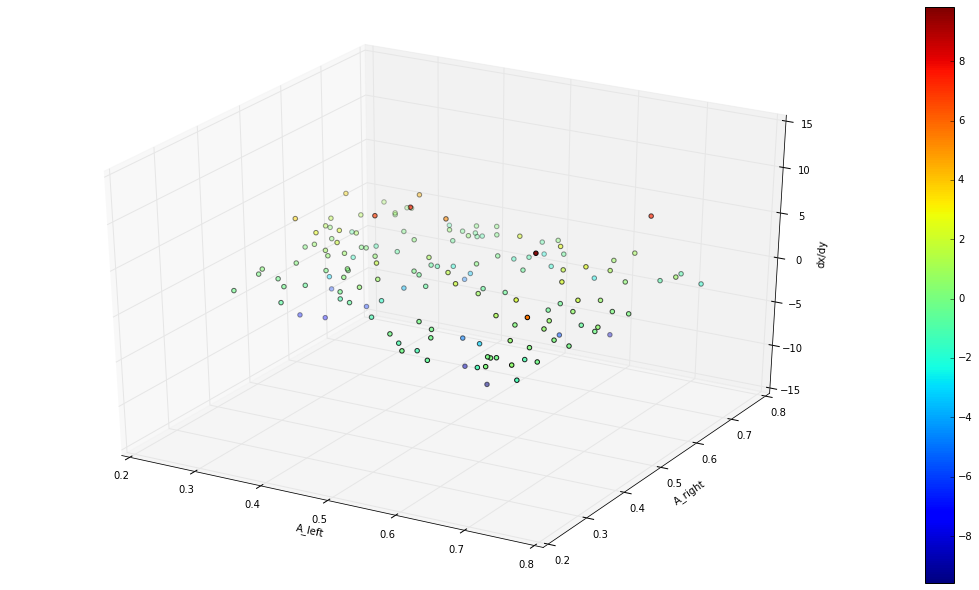

In [323]:
controls_po_25_50 = model.controls[(model.controls[:,0]>=0.25) & (model.controls[:,0]<=0.50)]
print controls_po_25_50.shape
end_states_po_25_50 = model.end_states[(model.controls[:,0]>=0.25) & (model.controls[:,0]<=0.50)]
print end_states_po_25_50.shape
dy_e = end_states_po_25_50[:,0] - end_states_po_25_50[:,26]
dx_e = end_states_po_25_50[:,1] - end_states_po_25_50[:,27]
slope = dx_e/dy_e
print slope.shape

# cm = plt.get_cmap("RdYlGn")
# fig = plt.figure()
# ax = plt.subplot(111, projection='3d')
# # c = plt.scatter(model.controls[:,2],slope, c='r')
# # plt.ylim([-15,15])
# ax.plot(controls_po_25_50[:,2],controls_po_25_50[:,3],slope, 
#         ms=2, marker='o', c=[cm(i) for i in slope/np.max(slope)] )
# ax.set_xlabel("A_left")
# ax.set_ylabel("A_right")
# # plt.zlabel("dx/dy")
# ax.set_zlabel("dx/dy")
# ax.set_zlim([-5,5])
# plt.show()

scatter3d(controls_po_25_50[:,2][(slope<10) & (slope>-10)],controls_po_25_50[:,3][(slope<10) & (slope>-10)],slope[(slope<10) & (slope>-10)], slope[(slope<10) & (slope>-10)])

Size:  (1774, 91)


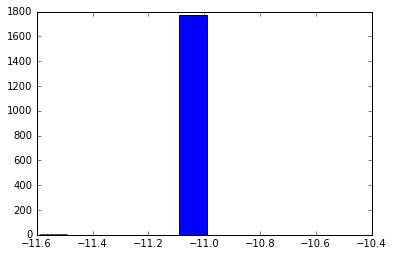

Size:  (1774, 91)


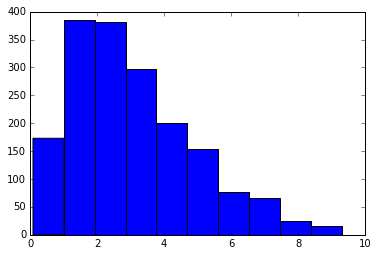

In [26]:
idx = 39

print "Size: ", model.start_states.shape
plt.figure(1)
plt.hist(model.start_states[:,idx])
plt.show()

print "Size: ", model.end_states.shape
plt.figure(2)
plt.hist(np.sqrt(np.square(model.end_states[:,idx] - model.start_states[:,idx]) + 
         np.square(model.end_states[:,idx+1] - model.start_states[:,idx+1])))
plt.show()


In [6]:
dx_e = model.end_states[:,0] - model.end_states[:,26]
dy_e = model.end_states[:,1] - model.end_states[:,27]
slope = dx_e/dy_e
print slope
plt.figure(3)
# plt.hist(slope)
bins = np.linspace(-25,25,40)
n, bins_out, plot = plt.hist(slope, 
                         bins, alpha=0.5, label="pred")
plt.show()

[ -1.39484262e+00  -8.96256685e-01  -5.18211842e-01  -5.26330233e-01
   8.17207432e+00   5.02377868e-01   4.43460315e-01  -4.99783516e-01
  -1.46111178e+00  -9.46809590e-01   8.20417166e-01   9.05434012e-01
  -1.66886353e+00   2.71270961e-01   1.77884400e-01  -5.49472094e-01
  -1.76236403e+00  -1.18169546e+00   6.87397182e-01   2.82314968e+00
  -6.11861169e-01  -3.51144820e-01   1.60206831e+00  -6.99936724e+00
  -1.00346327e+00   1.42682004e+00  -6.82294428e-01   1.10877144e+00
   2.33881998e+00   8.16292614e-02  -9.65542078e-01  -1.04503475e-01
   5.82238817e+00   1.35525549e-02  -2.57317719e+02  -4.05156434e-01
  -6.26314998e-01  -3.01153469e+00   1.07591665e+00  -9.94477940e+00
  -1.15931354e-01   4.48381233e+00  -1.72490239e+00  -2.02648711e+00
   7.38834143e-01  -1.62317634e-01  -1.67696369e+00   4.52492177e-01
  -1.40631235e+00  -3.08823490e+01   4.03257320e-03   3.93429446e+00
  -3.54464889e-01  -1.23309232e-01  -4.09583747e-01  -8.83768141e-01
   1.63140178e+00  -2.69220662e+00